# Hi

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sla


In [2]:
%matplotlib notebook
plt.style.use('ggplot')

## Create dataset 

Moving wave signal in 1-D with some random noise thrown in.

* Variables are the different x positions, specifically the value of the amplitude at that x position
* Samples are different time steps

Thus, our data matrix is $N$ samples by $M$ variables, where $N$ is the number of timesteps and $M$ the number of different x positions. 

<IPython.core.display.Javascript object>


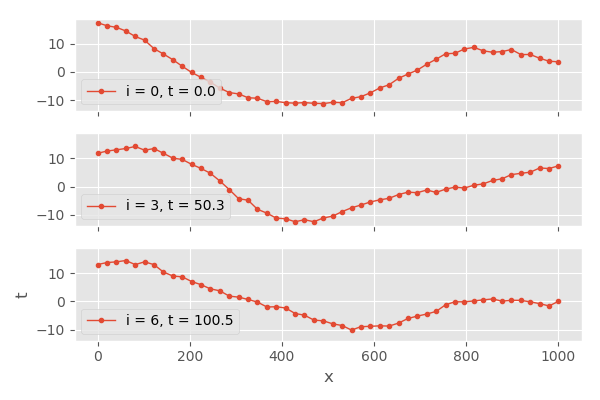

In [3]:
#> signal will be a sum of 3 waves
wls = np.array([1000, 700, 400])  # wavelength (in x direction)
ks = 2*np.pi/wls  # wavenumber in x direction
C = 10  # speed of mean wind advecting the waves
cs = np.array([10, 50, 100])  # wave speed
ws = 2*np.pi/cs  # wave angular frequency omega
As = np.array([10, 5, 2])  # amplitudes
A_noise = 0.5

def clean_sig(t, x):
    """only properly broadcasts for float x"""
    return ( As*np.cos(ks*x - ws*t) ).sum()
clean_sig = np.vectorize(clean_sig)

N = 200
M = 50
x = np.linspace(0, 1000, M)
t = np.linspace(0, 10000, N)

X = np.zeros((N, M))  # pre-allocate data matrix
for i, t_i in enumerate(t):
    X[i,:] = clean_sig(t_i, x) + np.random.normal(loc=0, scale=A_noise, size=x.size)

    
i_plots = [0, 3, 6]
f1, aa = plt.subplots(len(i_plots), 1, 
                      figsize=(6, 4), sharex=True, sharey=True)
for i, i_plot in enumerate(i_plots):
    ax = aa[i]
    l = 'i = {i:d}, t = {t:.1f}'.format(i=i_plot, t=t[i])
    ax.plot(x, X[i_plot,:], '.-', lw=1, label=l)
    ax.legend(loc='lower left')

ax.set_xlabel('x')
ax.set_ylabel('t')
f1.tight_layout();

## Implement PCA

<IPython.core.display.Javascript object>


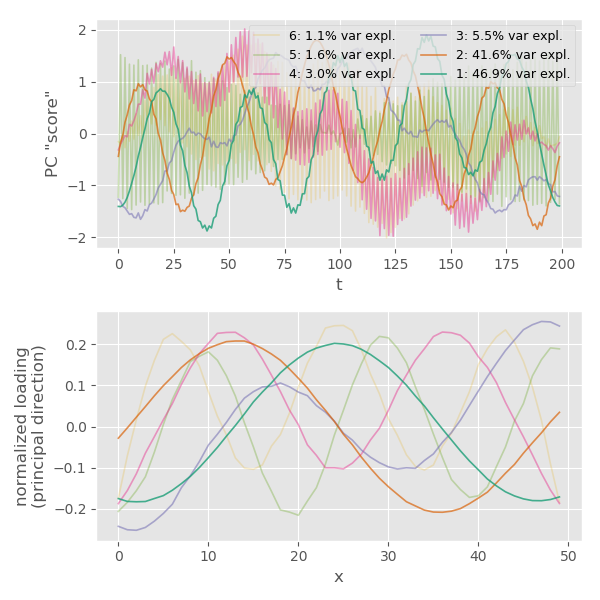

In [4]:
Xp = X - X.mean(axis=0)

#> SVD
U, s, V_T = sla.svd(Xp, full_matrices=False)
S = sla.diagsvd(s, *X.shape)
V = V_T.T

#> calculate PCA stuff from the SVD results
PCs = X @ V  # principal components (columns)
normalized_PCs1 = np.sqrt(N-1) * U
PDs = V      # principal directions (cols)
eigvals = s**2/(N-1)
normalized_PCs2 = (PCs - PCs.mean(axis=0))/np.sqrt(eigvals)

#loadings = np.sqrt(eigs) * PDs  # loadings (cols)
#loadings = np.sqrt(eigs)[np.newaxis,:] * PDs
#loadings = np.diag(np.sqrt(eigs)) @ PDs  # incorrect!
loadings = PDs @ np.diag(np.sqrt(eigvals))

var_expl = eigvals/eigvals.sum()

#> some checks
#assert(np.allclose(PCs.T @ PCs, np.eye(N)))
assert(np.allclose(PDs.T @ PDs, np.eye(M)))  # principal directions are orthog
assert(np.allclose(loadings.T @ loadings, np.eye(M)*eigvals))  # loadings too, though the matrix is not !
assert(np.allclose(sla.norm(loadings, axis=0), np.sqrt(eigvals)))  # check loading vectors are scaled correctly
assert(np.isclose(np.trace(loadings.T @ loadings), eigvals.sum()))
assert(np.isclose(np.trace(np.corrcoef(PCs.T)), M))  # PCs are uncorrelated
assert(np.allclose(normalized_PCs1, normalized_PCs2))

#> plot
n_retain = 6

colors = plt.cm.Dark2(np.linspace(0, 1, 8))[:8]
leg_fs = 9

f2, [a1, a2] = plt.subplots(2, 1, figsize=(6, 6), num='PCs')

for j in range(n_retain-1, 0-1, -1):  # plot PCs in reverse order
    s = '{:d}: {:.1f}% var expl.'.format(j+1, var_expl[j]*100)
    pc_j = PCs[:,j]
    alpha = 0.2 + 0.6*(n_retain-1-j)/(n_retain-1) if n_retain>4 else 0.8
    #print(pc_j.mean())
    a1.plot((pc_j - pc_j.mean())/np.sqrt(eigvals[j]), 
           c=colors[j], lw=1.2, alpha=alpha, label=s)

    a2.plot(PDs[:,j], c=colors[j], lw=1.2, alpha=alpha)
    

a1.set_xlabel('t')
a1.set_ylabel('PC "score"')
a2.set_xlabel('x')
a2.set_ylabel('normalized loading\n(principal direction)')
    
ncol = 1 if n_retain <= 4 else 2
a1.legend(loc='upper right', ncol=ncol, fontsize=leg_fs, frameon=True)

f2.tight_layout();

## Apply varimax rotation

Adapted from https://github.com/EducationalTestingService/factor_analyzer/blob/master/factor_analyzer/rotator.py

sum PDs_rot . PDs_rot = 3.35


<IPython.core.display.Javascript object>


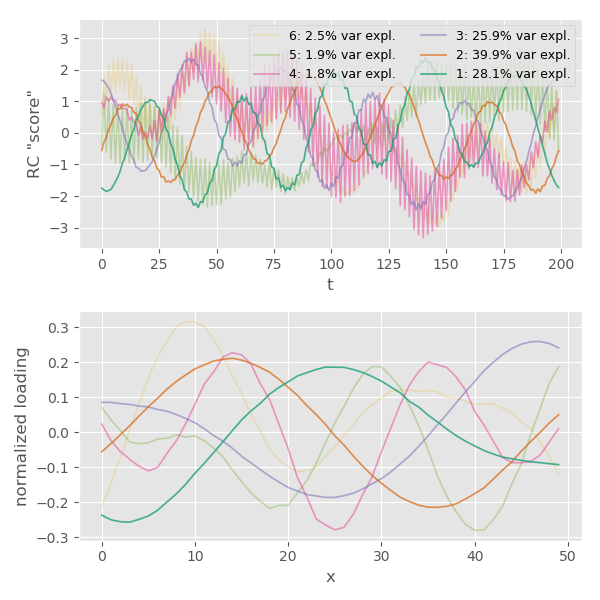

In [5]:

normalize = False
max_iter = 500
tolerance = 1e-6

L = loadings[:,:n_retain].copy()  # or can use the PDs??

n_rows, n_cols = L.shape

# normalize the loadings matrix
# using sqrt of the sum of squares (Kaiser)
if normalize:
    norms = sla.norm(L, axis=0)
    L = 1/norms * L

# initialize the rotation matrix
# to N x N identity matrix
T = np.eye(n_cols)

d = 0
for i in range(max_iter):

    old_d = d

    # take inner product of loading matrix
    # and rotation matrix
    basis = L @ T

    # transform data for singular value decomposition
    transformed = L.T @ (basis**3 - (1.0/n_rows) *
                  (basis @ np.diag(np.diag(basis.T @ basis))) )

    # perform SVD on
    # the transformed matrix
    U, s, V_T = sla.svd(transformed)

    # take inner product of U and V, and sum of S
    T = U @ V_T  # rotation matrix
    d = s.sum()

    # check convergence
    if old_d != 0 and d/old_d < 1 + tolerance:
        break

# take inner product of loading matrix
# and rotation matrix
Lp = L @ T

# de-normalize the data
#if normalize:
#    Lp = Lp.T * normalized_mtx
#else:
#    Lp = Lp.T


norms = sla.norm(Lp, axis=0)
eigvals = norms**2
var_expl = eigvals/eigvals.sum()

PDs_rot = 1/norms * Lp
#assert(np.allclose(PDs_rot, V.T))

RCs = X @ PDs_rot

#> some checks
assert(np.isclose(np.trace(np.corrcoef(RCs.T)), n_retain))  # RCs should be still uncorrelated
assert(~np.allclose((PDs_rot.T @ PDs_rot), np.eye(n_retain)))  # PDs no longer orthog!
print('sum PDs_rot . PDs_rot = {:.3}'.format((PDs_rot.T @ PDs_rot).sum()))

f3, [a1, a2] = plt.subplots(2, 1, figsize=(6, 6), num='rotated components')

for j in range(n_retain-1, 0-1, -1):  # plot PCs in reverse order
    s = '{:d}: {:.1f}% var expl.'.format(j+1, var_expl[j]*100)
    pc_j = RCs[:,j]
    alpha = 0.2 + 0.6*(n_retain-1-j)/(n_retain-1) if n_retain>4 else 0.8
    a1.plot((pc_j - pc_j.mean())/np.sqrt(eigvals[j]),
           c=colors[j], lw=1.2, alpha=alpha, label=s)

    a2.plot(PDs_rot[:,j], c=colors[j], lw=1.2, alpha=alpha)
    

a1.set_xlabel('t')
a1.set_ylabel('RC "score"')
a2.set_xlabel('x')
a2.set_ylabel('normalized loading')
    
ncol = 1 if n_retain <= 4 else 2
a1.legend(loc='upper right', ncol=ncol, fontsize=leg_fs, frameon=True)

f3.tight_layout();

In [6]:
np.diag(np.diag(basis.T @ basis))

array([[ 909.92727228,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        , 1292.97440646,    0.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,  840.19886877,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,   57.31321581,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
          61.47540209,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,   79.56823649]])

In [7]:
(PDs_rot.T @ PDs_rot)

array([[ 1.        , -0.15628842, -0.73691205, -0.14934942,  0.03803791,
        -0.2455203 ],
       [-0.15628842,  1.        , -0.18634422,  0.03794245, -0.09493035,
         0.118388  ],
       [-0.73691205, -0.18634422,  1.        ,  0.1604923 , -0.14852567,
         0.1125902 ],
       [-0.14934942,  0.03794245,  0.1604923 ,  1.        , -0.28719943,
         0.36424578],
       [ 0.03803791, -0.09493035, -0.14852567, -0.28719943,  1.        ,
        -0.14967884],
       [-0.2455203 ,  0.118388  ,  0.1125902 ,  0.36424578, -0.14967884,
         1.        ]])

In [8]:
np.array([1, 2, 3]) * np.ones((3, 3))

array([[1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.]])

In [9]:
np.ones((3, 3)) * np.array([1, 2, 3])

array([[1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.]])

In [10]:
np.array([1, 2, 3])[:,np.newaxis] * np.ones((3, 3))

array([[1., 1., 1.],
       [2., 2., 2.],
       [3., 3., 3.]])